<a href="https://colab.research.google.com/github/Koanah/CNNs_rediscovered-/blob/main/RetinaNet25Epochs_CNNLuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# STEP 0: Install dependencies
# ============================================================
!pip install torch torchvision torchaudio --upgrade
!pip install SimpleITK
!pip install pandas matplotlib opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [2]:
# ============================================================
# STEP 1: Imports
# ============================================================
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_PATH = "/content/drive/MyDrive/LUNA16_trial"

In [5]:
# ============================================================
# STEP 2: Safe scan loader (clean version)
# ============================================================

def load_luna_scans(base_path):
    """
    Load all LUNA16 scans safely.
    Returns a dictionary: {scan_id: SimpleITK image}
    Skips missing or corrupt scans silently.
    """
    scans = {}
    skipped = []

    for i in range(10):
        subset_path = os.path.join(base_path, f"subset{i}")
        if not os.path.exists(subset_path):
            continue
        for file in os.listdir(subset_path):
            if file.endswith(".mhd"):
                mhd_path = os.path.join(subset_path, file)
                raw_path = mhd_path.replace(".mhd", ".raw")
                if not os.path.exists(raw_path):
                    skipped.append(file)
                    continue
                try:
                    scan = sitk.ReadImage(mhd_path)
                    scans[file.replace(".mhd","")] = scan
                except:
                    skipped.append(file)

    print(f"✅ Loaded {len(scans)} scans successfully")
    print(f"❌ Skipped {len(skipped)} scans (missing/corrupt)")
    return scans

scans = load_luna_scans(BASE_PATH)
#print(f"Loaded {len(scans)} scans successfully")

✅ Loaded 708 scans successfully
❌ Skipped 178 scans (missing/corrupt)


In [6]:
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations.csv")
annotations_df = pd.read_csv(ANNOTATIONS_PATH)
print(f" Loaded {len(annotations_df)} annotation entries")

 Loaded 1186 annotation entries


In [7]:
!pip install albumentations==1.4.7 --quiet

import os, math, random, copy
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
import albumentations as A
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.anchor_utils import AnchorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, roc_curve, auc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 16.6 MB/s eta 0:00:00


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", DEVICE)
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations.csv")
ann = pd.read_csv(ANNOTATIONS_PATH)
print(f" Loaded annotations: {len(ann)} rows, {ann['seriesuid'].nunique()} unique series")

 Device: cuda
 Loaded annotations: 1186 rows, 601 unique series


In [9]:
# ------------------------------------------------------------
# Helper: safe HU → [0,1] normalization
# ------------------------------------------------------------
def hu_to_float01(arr, hu_min=-1000, hu_max=400):
    arr = np.clip(arr, hu_min, hu_max)
    arr = (arr - hu_min) / float(hu_max - hu_min + 1e-6)
    return arr.astype(np.float32)

In [10]:

# Dataset: build slice-level samples directly from annotations
# - Positive samples: one per annotation (centered slice)
# - Negative samples: sampled slices far from any annotation

class LunaRetinaDataset(Dataset):
    def __init__(self, scans_dict, annotations_df, split_ids,
                 patch_size=512, neg_per_pos=1, min_diam_mm=2.0, aug=True):
        """
        scans_dict: {seriesuid: SimpleITK.Image}
        annotations_df: columns seresuid, coordX, coordY, coordZ, diameter_mm]
        split_ids: list of seriesuids to include
        neg_perpos: number of negative slices per psitive slice
        """
        self.items = []   # list of tuples: (uid, z_index, boxes_xyxy_in_pixels)
        self.patch_size = patch_size
        self.scans = scans_dict
        self.aug = aug

        # albumentations – keep light & safe for medical data, update bboxes
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Affine(scale=(0.95,1.05), translate_percent=(0.0,0.05),
                     rotate=(-5,5), shear=(-3,3), fit_output=False, p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_labels'], min_visibility=0.2))

        # Precompute for faster neg sampling: nodules per series
        ann_sel = annotations_df[annotations_df["seriesuid"].isin(split_ids)].copy()
        ann_sel = ann_sel[ann_sel["diameter_mm"] >= min_diam_mm]
        grouped = ann_sel.groupby("seriesuid")
        pos_count = 0
        neg_count = 0

        for uid in split_ids:
            if uid not in self.scans:
                continue
            img3d = self.scans[uid]
            arr3d = sitk.GetArrayFromImage(img3d)  # [z,y,x]
            depth, H, W = arr3d.shape
            origin = np.array(img3d.GetOrigin(), dtype=np.float64)
            spacing = np.array(img3d.GetSpacing(), dtype=np.float64)

            # Helper to world→index (integer voxel index)
            def world_to_index(xyz):
                idx = img3d.TransformPhysicalPointToIndex(tuple(map(float, xyz)))
                # SimpleITK returns (x_idx, y_idx, z_idx)
                return np.array(idx, dtype=np.int64)

            # Positive samples for this uid
            if uid in grouped.groups:
                for _, row in grouped.get_group(uid).iterrows():
                    world = np.array([row.coordX, row.coordY, row.coordZ], dtype=np.float64)
                    diam_mm = float(row.diameter_mm)

                    # voxel index (x_idx, y_idx, z_idx)
                    ijk = world_to_index(world)
                    x_idx, y_idx, z_idx = int(ijk[0]), int(ijk[1]), int(ijk[2])
                    if not (0 <= z_idx < depth):  # skip if outside
                        continue

                    # convert mm diameter to pixel radius along x/y
                    rx = (diam_mm / 2.0) / (spacing[0] + 1e-6)
                    ry = (diam_mm / 2.0) / (spacing[1] + 1e-6)

                    # build bbox in original pixel coords (x1,y1,x2,y2)
                    x1 = max(0, int(round(x_idx - rx)))
                    y1 = max(0, int(round(y_idx - ry)))
                    x2 = min(W-1, int(round(x_idx + rx)))
                    y2 = min(H-1, int(round(y_idx + ry)))
                    if x2 <= x1 or y2 <= y1:
                        continue

                    self.items.append((uid, z_idx, np.array([[x1,y1,x2,y2]], dtype=np.float32)))
                    pos_count += 1

            # Negative samples: pick slices away from any positive z
            pos_zs = set()
            if uid in grouped.groups:
                for _, row in grouped.get_group(uid).iterrows():
                    z_idx = int(world_to_index([row.coordX, row.coordY, row.coordZ])[2])
                    if 0 <= z_idx < depth:
                        pos_zs.add(z_idx)

            # choose neg_per_pos * #positives negative slices, skip near positives
            n_pos_uid = max(1, sum(1 for it in self.items if it[0]==uid))
            n_negs = min(depth, neg_per_pos * n_pos_uid)
            chosen = 0
            tries = 0
            while chosen < n_negs and tries < 10 * n_negs:
                z = random.randint(0, depth-1)
                tries += 1
                # keep negatives at least 3 slices away from any positive slice
                if all(abs(z - pz) > 3 for pz in pos_zs):
                    self.items.append((uid, z, np.zeros((0,4), dtype=np.float32)))
                    chosen += 1
                    neg_count += 1

        print(f" Built dataset: {pos_count} positives, {neg_count} negatives, total {len(self.items)} samples")

    def __len__(self):
        return len(self.items)

    def _resize_and_scale_boxes(self, img2d, boxes):
        H, W = img2d.shape
        sx = self.patch_size / float(W)
        sy = self.patch_size / float(H)
        img_resized = cv2.resize(img2d, (self.patch_size, self.patch_size), interpolation=cv2.INTER_LINEAR)
        if boxes is None or len(boxes)==0:
            return img_resized, np.zeros((0,4), dtype=np.float32)
        scaled = boxes.copy()
        scaled[:, [0,2]] = np.clip(np.round(scaled[:, [0,2]] * sx), 0, self.patch_size-1)
        scaled[:, [1,3]] = np.clip(np.round(scaled[:, [1,3]] * sy), 0, self.patch_size-1)
        # filter tiny
        keep = (scaled[:,2] > scaled[:,0]) & (scaled[:,3] > scaled[:,1])
        return img_resized, scaled[keep]

    def __getitem__(self, idx):
        uid, z_idx, boxes = self.items[idx]
        img3d = self.scans[uid]
        arr3d = sitk.GetArrayFromImage(img3d)  # [z,y,x]
        depth, H, W = arr3d.shape
        z = int(np.clip(z_idx, 0, depth-1))
        img2d = hu_to_float01(arr3d[z])

        # resize & scale bboxes to output resolution
        img_resized, boxes_scaled = self._resize_and_scale_boxes(img2d, boxes)

        # albumentations expects HWC + bboxes in pascal_voc
        if self.aug and random.random() < 0.9:
            bboxes = boxes_scaled.tolist()
            labels = [1]*len(bboxes)
            aug = self.transform(image=(img_resized*255).astype(np.uint8), bboxes=bboxes, bbox_labels=labels)
            img_resized = aug["image"].astype(np.float32) / 255.0
            boxes_scaled = np.array(aug["bboxes"], dtype=np.float32) if len(aug["bboxes"])>0 else np.zeros((0,4), np.float32)

        # to CHW, 3 channels
        img_chw = np.stack([img_resized, img_resized, img_resized], axis=0).astype(np.float32)

        target = {
            "boxes": torch.tensor(boxes_scaled, dtype=torch.float32),
            "labels": torch.tensor(np.ones(len(boxes_scaled), dtype=np.int64), dtype=torch.int64)
        }
        return torch.tensor(img_chw, dtype=torch.float32), target

def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
# ------------------------------------------------------------
# Split – use only series present in scans
# ------------------------------------------------------------
all_ids = [k for k in scans.keys() if k in set(ann['seriesuid'])]
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

train_ds = LunaRetinaDataset(scans, ann, train_ids, patch_size=512, neg_per_pos=1, aug=True)
val_ds   = LunaRetinaDataset(scans, ann, val_ids,   patch_size=512, neg_per_pos=1, aug=False)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f" Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")

 Built dataset: 756 positives, 756 negatives, total 1512 samples
 Built dataset: 192 positives, 192 negatives, total 384 samples
 Train samples: 1512 | Val samples: 384


In [30]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

anchor_gen = AnchorGenerator(
    sizes=((16,), (32,), (64,), (128,), (256,)),   # one per FPN level
    aspect_ratios=((0.5, 1.0, 2.0),) * 5          # same aspect ratios for all
)
print(" RetinaNet anchor generator configured correctly for 5 FPN levels.")


 RetinaNet anchor generator configured correctly for 5 FPN levels.


In [31]:
# ------------------------------------------------------------
# Model: RetinaNet + small anchors (backbone pretrained only)
# ------------------------------------------------------------
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Define anchor generator for small nodules
# Sizes: pixel areas for anchors on the input image (512x512)
# Aspect ratios: width/height ratios



try:
    # torch/torchvision >= 0.13 supports weights enums
    from torchvision.models import ResNet50_Weights
    backbone_weights = ResNet50_Weights.IMAGENET1K_V2
    model = retinanet_resnet50_fpn(
        weights=None,                              # <-- do NOT load COCO head
        weights_backbone=backbone_weights,         # <-- use pretrained backbone
        num_classes=2,
        anchor_generator=anchor_gen
    )
except Exception:
    # Fallback for older torchvision: weights_backbone="DEFAULT" often works
    model = retinanet_resnet50_fpn(
        weights=None,
        weights_backbone="DEFAULT",
        num_classes=2,
        anchor_generator=anchor_gen
    )

model.to(DEVICE)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [34]:
# ------------------------------------------------------------
# Optimizer, LR schedule, early stopping, best-save

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

scaler = torch.amp.GradScaler("cuda") if DEVICE.type == "cuda" else None
EPOCHS = 25  # icrease it from 15 to 25 to for better loss
patience = 4
best_val = float("inf")
no_improve = 0
best_path = "bestest_retinanet_luna16.pth"

In [35]:
print("Training RetinaNet...")
for epoch in range(EPOCHS):
    model.train()
    run_loss = 0.0
    for imgs, targets in train_loader:
        imgs = [img.to(DEVICE) for img in imgs]
        targets = [{k: v.to(DEVICE) for k,v in t.items()} for t in targets]

        optimizer.zero_grad()
        if scaler:
            with torch.amp.autocast("cuda"):
                loss_dict = model(imgs, targets)
                loss = sum(loss_dict.values())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(imgs, targets)
            loss = sum(loss_dict.values())
            loss.backward()
            optimizer.step()
        run_loss += loss.item()

    train_loss = run_loss / max(1, len(train_loader))

    # validation loss
    model.train()  # RetinaNet returns losses only in train mode
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [img.to(DEVICE) for img in imgs]
            targets = [{k: v.to(DEVICE) for k,v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            val_loss += sum(loss_dict.values()).item()
    val_loss = val_loss / max(1, len(val_loader))
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:02d}/{EPOCHS} - train loss {train_loss:.4f} - val loss {val_loss:.4f}")

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f" Saved best model (val {best_val:.4f})")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f" Early stopping at epoch {epoch+1} (best val {best_val:.4f})")
            break

print(f" Training complete. Best: {best_val:.4f} saved to {best_path}")

Training RetinaNet...
Epoch 01/25 - train loss 0.3599 - val loss 0.3524
 Saved best model (val 0.3524)
Epoch 02/25 - train loss 0.3285 - val loss 0.3246
 Saved best model (val 0.3246)
Epoch 03/25 - train loss 0.3020 - val loss 0.3356
Epoch 04/25 - train loss 0.2846 - val loss 0.3025
 Saved best model (val 0.3025)
Epoch 05/25 - train loss 0.2687 - val loss 0.2925
 Saved best model (val 0.2925)
Epoch 06/25 - train loss 0.2586 - val loss 0.3072
Epoch 07/25 - train loss 0.2489 - val loss 0.3059
Epoch 08/25 - train loss 0.2364 - val loss 0.3016
Epoch 09/25 - train loss 0.2173 - val loss 0.2883
 Saved best model (val 0.2883)
Epoch 10/25 - train loss 0.2076 - val loss 0.2932
Epoch 11/25 - train loss 0.2050 - val loss 0.2974
Epoch 12/25 - train loss 0.1988 - val loss 0.2879
 Saved best model (val 0.2879)
Epoch 13/25 - train loss 0.1897 - val loss 0.3040
Epoch 14/25 - train loss 0.1859 - val loss 0.2983
Epoch 15/25 - train loss 0.1775 - val loss 0.3164
Epoch 16/25 - train loss 0.1768 - val loss

In [36]:
# ------------------------------------------------------------
# Evaluation – IoU-based, threshold sweep, PR/ROC
# ------------------------------------------------------------
def iou_xyxy(a, b):
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    iw = max(0, x2 - x1); ih = max(0, y2 - y1)
    inter = iw * ih
    ua = max(0, a[2]-a[0]) * max(0, a[3]-a[1]) + max(0, b[2]-b[0]) * max(0, b[3]-b[1]) - inter
    return inter / (ua + 1e-6)

model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

CONF_GRID = np.linspace(0.0005, 0.3, 25)
IOU_THRESH = 0.3

def eval_at_threshold(conf_thr):
    TP=FP=FN=TN=0
    y_img_true, y_img_scores = [], []
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs_dev = [img.to(DEVICE) for img in imgs]
            outs = model(imgs_dev)
            for out, tgt in zip(outs, targets):
                scores = out['scores'].detach().cpu().numpy()
                pboxes = out['boxes'].detach().cpu().numpy()
                keep = scores >= conf_thr
                pboxes = pboxes[keep]
                scores = scores[keep]
                gboxes = tgt['boxes'].numpy()

                y_img_true.append(1 if len(gboxes)>0 else 0)
                y_img_scores.append(float(scores.max()) if len(scores)>0 else 0.0)

                if len(gboxes)==0 and len(pboxes)==0: TN+=1; continue
                if len(gboxes)==0 and len(pboxes)>0:  FP+=1; continue
                if len(gboxes)>0 and len(pboxes)==0:  FN+=1; continue

                matched = set()
                for pb in pboxes:
                    ious = np.array([iou_xyxy(pb, gb) for gb in gboxes])
                    j = ious.argmax()
                    if ious[j] >= IOU_THRESH and j not in matched:
                        matched.add(j)
                    else:
                        FP += 1
                FN += (len(gboxes) - len(matched))
                TP += len(matched)

    prec = TP / (TP + FP + 1e-6)
    rec  = TP / (TP + FN + 1e-6)
    f1   = 2*prec*rec / (prec+rec+1e-6)
    try:
        roc_auc = roc_auc_score(np.array(y_img_true), np.array(y_img_scores))
    except:
        roc_auc = float("nan")
    return prec, rec, f1, roc_auc


In [37]:
best = {"thr":None,"p":0,"r":0,"f1":0,"auc":0}
for t in CONF_GRID:
    p,r,f1,auc_roc = eval_at_threshold(t)
    if f1 > best["f1"]:
        best = {"thr":t,"p":p,"r":r,"f1":f1,"auc":auc_roc}

In [38]:
print("\n RetinaNet (IoU≥0.3) – best over thresholds")
if best["thr"] is None:
    print(" No valid detections. Try lower CONF_GRID or IOU_THRESH=0.25")
else:
    print(f" Best threshold      : {best['thr']:.4f}")
    print(f" Precision           : {best['p']:.4f}")
    print(f" Recall (Sensitivity): {best['r']:.4f}")
    print(f" F1-Score            : {best['f1']:.4f}")
    print(f" ROC-AUC (img-level) : {best['auc']:.4f}")


 RetinaNet (IoU≥0.3) – best over thresholds
 Best threshold      : 0.2875
 Precision           : 0.7416
 Recall (Sensitivity): 0.8073
 F1-Score            : 0.7731
 ROC-AUC (img-level) : 0.8907


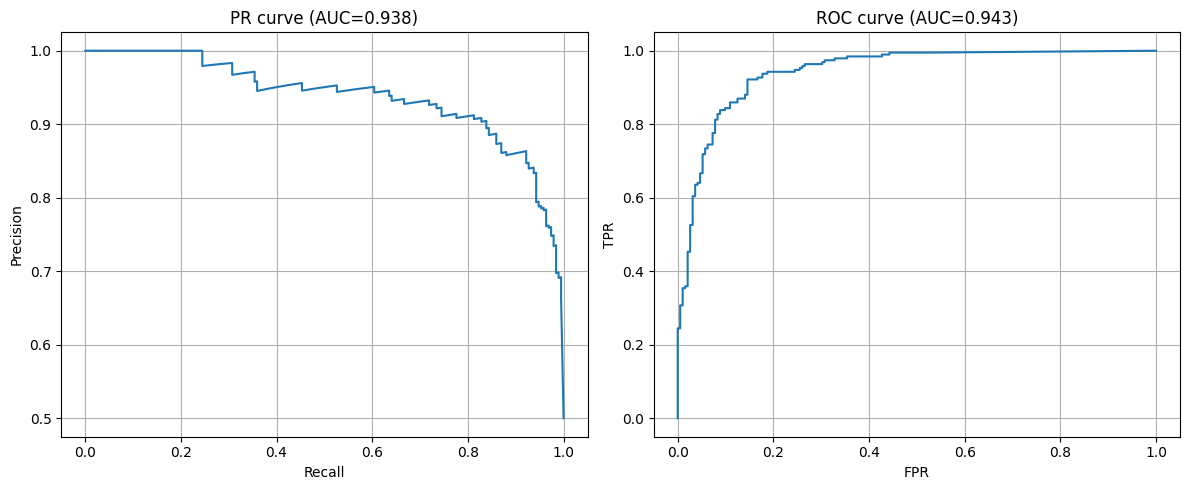


 Done.


In [39]:
# PR & ROC curves (image-level max score)
y_true, y_scores = [], []
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs_dev = [img.to(DEVICE) for img in imgs]
        outs = model(imgs_dev)
        for out, tgt in zip(outs, targets):
            score = float(out['scores'].max().item()) if len(out['scores'])>0 else 0.0
            y_scores.append(score)
            y_true.append(1 if len(tgt['boxes'])>0 else 0)

y_true = np.array(y_true); y_scores = np.array(y_scores)
prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_scores)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR curve (AUC={auc(rec_curve,prec_curve):.3f})"); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(fpr, tpr)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC curve (AUC={roc_auc_val:.3f})"); plt.grid(True)
plt.tight_layout(); plt.show()

print("\n Done.")

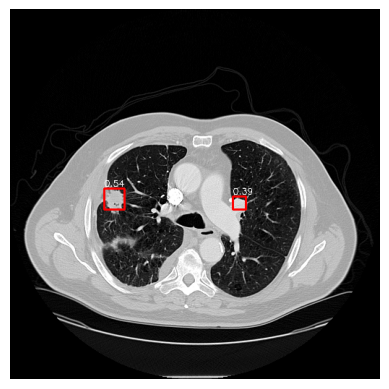

In [40]:
import matplotlib.pyplot as plt, cv2
model.eval()
with torch.no_grad():
    imgs, targets = next(iter(val_loader))
    imgs = [img.to(DEVICE) for img in imgs]
    outs = model(imgs)

img = imgs[0][0].cpu().numpy()  # first channel of first image
img = (img * 255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for box, score in zip(outs[0]['boxes'], outs[0]['scores']):
    if score > 0.275:  # your best threshold
        x1, y1, x2, y2 = map(int, box.cpu().numpy())
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255), 2)
        cv2.putText(img, f"{score:.2f}", (x1, y1-3),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
plt.imshow(img[...,::-1]); plt.axis("off"); plt.show()



 Sample UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992
World coord (mm): [ -78.23081813   21.39196957 -185.9204699 ]
Voxel indices   : x=142, y=283, z=77
Diameter (mm): 11.84 → approx. 7.6px × 7.6px


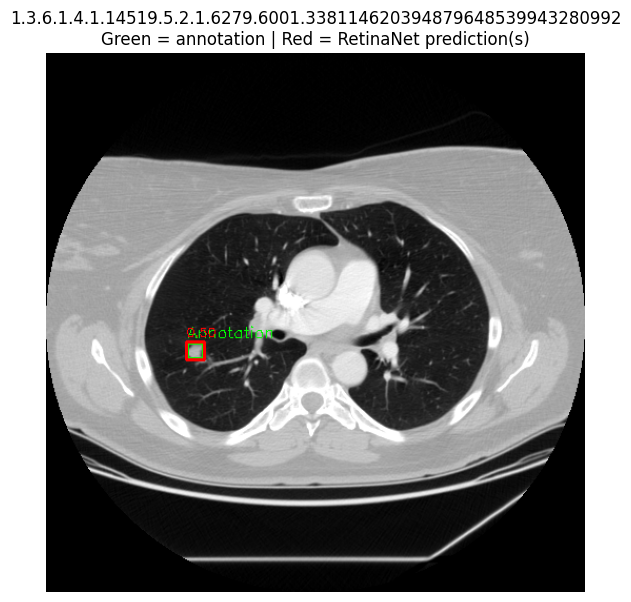

In [42]:
# ============================================================
# Visual check: ground-truth (annotation) vs RetinaNet predictions
# ============================================================
import cv2, matplotlib.pyplot as plt, numpy as np

# Choose a scan that has annotations and predictions ---
sample_uid = random.choice(list(val_ids))

# Get the scan and its 3D array
scan = scans[sample_uid]
arr3d = sitk.GetArrayFromImage(scan)  # shape [z, y, x]
origin = np.array(scan.GetOrigin())
spacing = np.array(scan.GetSpacing())
direction = np.array(scan.GetDirection()).reshape(3, 3)

# Get annotations (in world coordinates)
df = ann[ann["seriesuid"] == sample_uid]
if len(df) == 0:
    print(f"No nodules for {sample_uid}")
else:
    # We'll just visualize the first nodule
    row = df.iloc[0]
    world = np.array([row.coordX, row.coordY, row.coordZ])
    diameter_mm = row.diameter_mm

    # Convert world (mm) → voxel indices
    voxel = np.linalg.inv(direction).dot((world - origin) / spacing)
    z_idx = int(round(voxel[2]))
    y_idx = int(round(voxel[1]))
    x_idx = int(round(voxel[0]))
    radius_px_x = (diameter_mm / 2) / spacing[0]
    radius_px_y = (diameter_mm / 2) / spacing[1]

    print(f"\n Sample UID: {sample_uid}")
    print(f"World coord (mm): {world}")
    print(f"Voxel indices   : x={x_idx}, y={y_idx}, z={z_idx}")
    print(f"Diameter (mm): {diameter_mm:.2f} → approx. {radius_px_x:.1f}px × {radius_px_y:.1f}px")

    # Extract the 2D slice where the nodule lies
    slice2d = arr3d[z_idx]
    slice_norm = (hu_to_float01(slice2d) * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(slice_norm, cv2.COLOR_GRAY2BGR)

    # Draw the annotation bounding box (from original coords) ---
    x1 = int(x_idx - radius_px_x)
    y1 = int(y_idx - radius_px_y)
    x2 = int(x_idx + radius_px_x)
    y2 = int(y_idx + radius_px_y)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_rgb, "Annotation", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    #  Get RetinaNet prediction for the same slice ---
    model.eval()
    with torch.no_grad():
        # preprocess like during training
        img_resized = cv2.resize(slice_norm, (512, 512)).astype(np.float32) / 255.0
        img_t = torch.tensor(np.stack([img_resized]*3, axis=0)).unsqueeze(0).to(DEVICE)
        preds = model(img_t)[0]

    # scale boxes back to original slice resolution
    h0, w0 = slice2d.shape
    sx, sy = w0 / 512, h0 / 512
    for box, score in zip(preds['boxes'], preds['scores']):
        if score > 0.275:  # use your best threshold
            x1p, y1p, x2p, y2p = box.cpu().numpy()
            x1p, y1p, x2p, y2p = map(int, [x1p*sx, y1p*sy, x2p*sx, y2p*sy])
            cv2.rectangle(img_rgb, (x1p, y1p), (x2p, y2p), (0, 0, 255), 2)
            cv2.putText(img_rgb, f"{score:.2f}", (x1p, y1p - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

    plt.figure(figsize=(7,7))
    plt.imshow(img_rgb[...,::-1])
    plt.title(f"{sample_uid}\nGreen = annotation | Red = RetinaNet prediction(s)")
    plt.axis("off")
    plt.show()



 Sample UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774
World coord (mm): [   2.26381589   33.52641757 -170.6369497 ]
Voxel indices   : x=251, y=310, z=63
Diameter (mm): 7.17 → approx. 5.7px × 5.7px


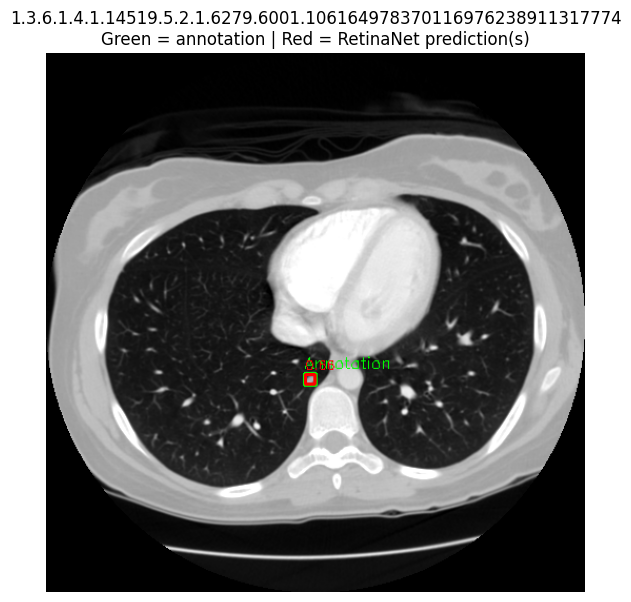

In [43]:
# ============================================================
# Visual check: ground-truth (annotation) vs RetinaNet predictions
# ============================================================
import cv2, matplotlib.pyplot as plt, numpy as np

# Choose a scan that has annotations and predictions ---
sample_uid = random.choice(list(val_ids))

# Get the scan and its 3D array
scan = scans[sample_uid]
arr3d = sitk.GetArrayFromImage(scan)  # shape [z, y, x]
origin = np.array(scan.GetOrigin())
spacing = np.array(scan.GetSpacing())
direction = np.array(scan.GetDirection()).reshape(3, 3)

# Get annotations (in world coordinates)
df = ann[ann["seriesuid"] == sample_uid]
if len(df) == 0:
    print(f"No nodules for {sample_uid}")
else:
    # We'll just visualize the first nodule
    row = df.iloc[0]
    world = np.array([row.coordX, row.coordY, row.coordZ])
    diameter_mm = row.diameter_mm

    # Convert world (mm) → voxel indices
    voxel = np.linalg.inv(direction).dot((world - origin) / spacing)
    z_idx = int(round(voxel[2]))
    y_idx = int(round(voxel[1]))
    x_idx = int(round(voxel[0]))
    radius_px_x = (diameter_mm / 2) / spacing[0]
    radius_px_y = (diameter_mm / 2) / spacing[1]

    print(f"\n Sample UID: {sample_uid}")
    print(f"World coord (mm): {world}")
    print(f"Voxel indices   : x={x_idx}, y={y_idx}, z={z_idx}")
    print(f"Diameter (mm): {diameter_mm:.2f} → approx. {radius_px_x:.1f}px × {radius_px_y:.1f}px")

    # Extract the 2D slice where the nodule lies
    slice2d = arr3d[z_idx]
    slice_norm = (hu_to_float01(slice2d) * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(slice_norm, cv2.COLOR_GRAY2BGR)

    # Draw the annotation bounding box (from original coords) ---
    x1 = int(x_idx - radius_px_x)
    y1 = int(y_idx - radius_px_y)
    x2 = int(x_idx + radius_px_x)
    y2 = int(y_idx + radius_px_y)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_rgb, "Annotation", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    #  Get RetinaNet prediction for the same slice ---
    model.eval()
    with torch.no_grad():
        # preprocess like during training
        img_resized = cv2.resize(slice_norm, (512, 512)).astype(np.float32) / 255.0
        img_t = torch.tensor(np.stack([img_resized]*3, axis=0)).unsqueeze(0).to(DEVICE)
        preds = model(img_t)[0]

    # scale boxes back to original slice resolution
    h0, w0 = slice2d.shape
    sx, sy = w0 / 512, h0 / 512
    for box, score in zip(preds['boxes'], preds['scores']):
        if score > 0.275:  # use your best threshold
            x1p, y1p, x2p, y2p = box.cpu().numpy()
            x1p, y1p, x2p, y2p = map(int, [x1p*sx, y1p*sy, x2p*sx, y2p*sy])
            cv2.rectangle(img_rgb, (x1p, y1p), (x2p, y2p), (0, 0, 255), 2)
            cv2.putText(img_rgb, f"{score:.2f}", (x1p, y1p - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

    plt.figure(figsize=(7,7))
    plt.imshow(img_rgb[...,::-1])
    plt.title(f"{sample_uid}\nGreen = annotation | Red = RetinaNet prediction(s)")
    plt.axis("off")
    plt.show()


In [44]:
# ============================================================
# STAGE 1 → OUTPUT EXPORT: Save RetinaNet Candidate Predictions
# ============================================================
import csv

OUTPUT_CSV = os.path.join(BASE_PATH, "candidate_boxes.csv")
CONF_THRESHOLD = best['thr'] if best['thr'] else 0.25   # use best threshold found earlier

print(f"🔍 Exporting RetinaNet candidates with conf ≥ {CONF_THRESHOLD:.3f} ...")

model.eval()
records = []

with torch.no_grad():
    for imgs, targets in val_loader:
        imgs_dev = [img.to(DEVICE) for img in imgs]
        outs = model(imgs_dev)

        for img_tensor, out, tgt in zip(imgs, outs, targets):
            # Retrieve the original scan ID
            scan_id = tgt.get("scan_id", None)
            if scan_id is None:
                # If we didn’t store it in target, extract from dataset item
                scan_id = val_ds.items[0][0]  # fallback to series uid

            boxes = out['boxes'].cpu().numpy()
            scores = out['scores'].cpu().numpy()

            for box, score in zip(boxes, scores):
                if score < CONF_THRESHOLD:
                    continue
                x1, y1, x2, y2 = box.tolist()
                records.append([scan_id, x1, y1, x2, y2, score])

# Save to CSV
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["seriesuid", "x1", "y1", "x2", "y2", "score"])
    writer.writerows(records)

print(f"✅ Saved {len(records)} candidate boxes to: {OUTPUT_CSV}")


🔍 Exporting RetinaNet candidates with conf ≥ 0.288 ...
✅ Saved 209 candidate boxes to: /content/drive/MyDrive/LUNA16_trial/candidate_boxes.csv
